In [13]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import scanpy as sc 
import sys 
import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import glob

sys.path.append('../../src')

In [15]:
from spaceoracle.prophets import Prophet
from spaceoracle.plotting.cartography import xy_from_adata
from spaceoracle.plotting.cartography import Cartography

In [16]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3549
    obs: 'cell_type', 'author_cell_type', 'cell_type_int', 'leiden', 'leiden_R', 'cell_type_2'
    uns: 'author_cell_type_colors', 'cell_thresholds', 'cell_type_2_colors', 'cell_type_colors', 'dendrogram_leiden', 'leiden', 'leiden_R', 'leiden_colors', 'ligand_receivers', 'neighbors', 'pca', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count'
    obsp: 'connectivities', 'distances'

In [5]:
adata = adata[~adata.obs.cell_type.isin(['Macrophages'])]
adata = adata[~adata.obs.cell_type_2.isin(['DN T', 'pDC', 'mDC', 'fDC'])]

In [6]:
adata.obs.cell_type_2.value_counts()

cell_type_2
GC B        1581
B memory     873
B naive      715
CD4+ T       530
Plasma       490
Tfh          404
T memory     371
CD8+ T       175
Name: count, dtype: int64

In [7]:
xy = xy_from_adata(adata)

In [8]:
color_dict = {
    'CD4+ T': "#ea7465",
    'Tfh': "#b74329", 
    'CD8+ T': "#dd3652",
    'T memory': "#e28723",
    'GC B': "#1f84e9",
    'B memory': "#61c17c",
    'B naive': "#4b9131", 
    'Plasma': "#beb637",
    'fDC': "#98907f",
}

In [9]:
chart = Cartography(adata, color_dict)

In [10]:
ligands = ['IL7', 'IL4',  'IL6ST', 'GZMA']
receptors = ['CXCR4', 'CXCL12', 'CCR2', 'IL7R']
tf = ['GATA3', 'PAX5', 'FOXP3', 'BCL6', 'TBX21', 'PRDM1']

In [60]:
for i in ligands+receptors+tf:
    if i not in adata.var_names:
        print(i)

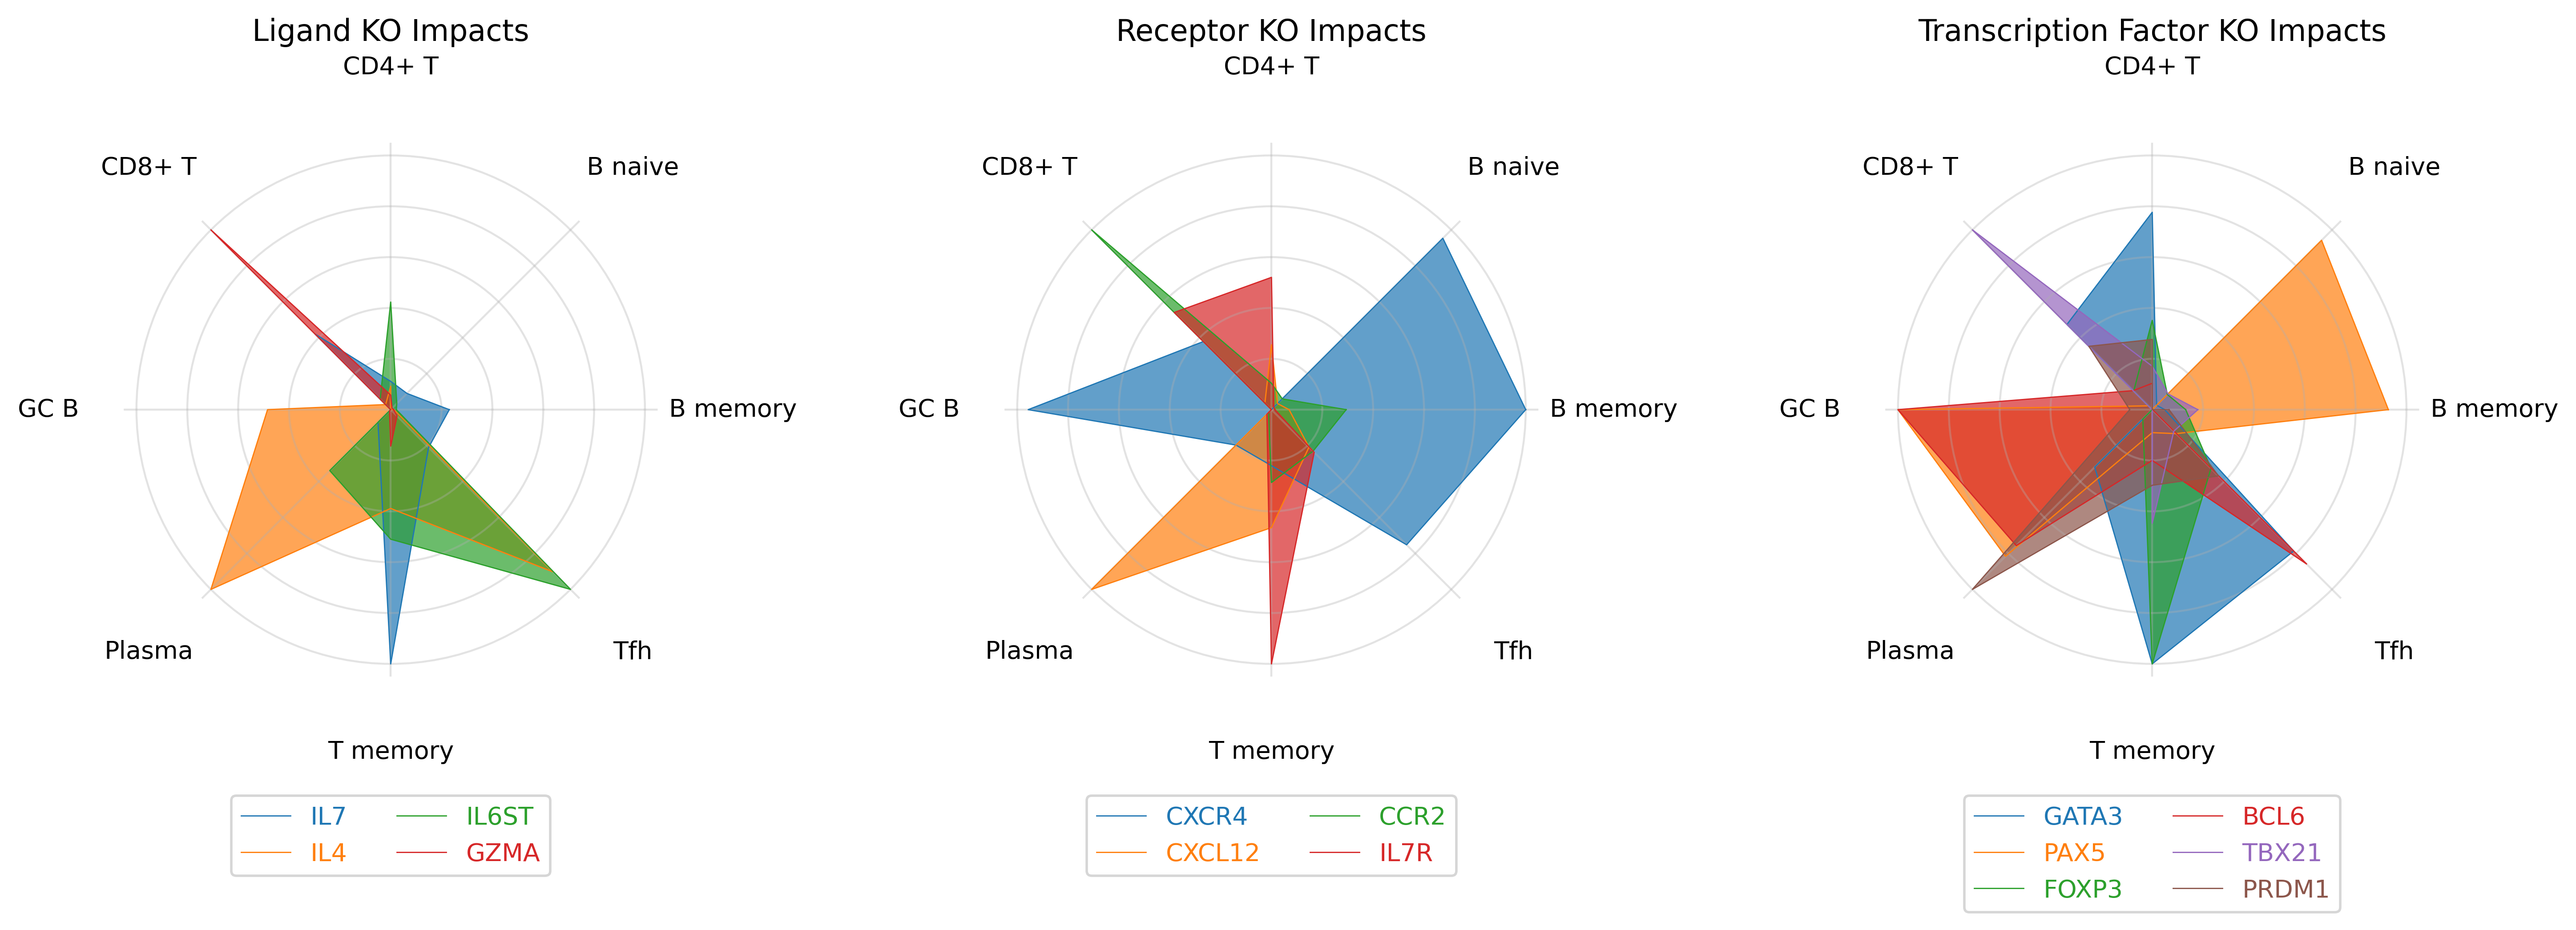

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200, subplot_kw={'projection': 'polar'})

# Helper function to plot radar chart
def plot_radar(kotargets, ax, title):
    for kotarget in kotargets:
        data = (pd.read_parquet(
            f'/Volumes/SSD/genome_screens/human_tonsil/{kotarget}_4n_0x.parquet').loc[
                chart.adata.obs_names
            ]-chart.adata.to_df(layer='imputed_count')
            ).join(chart.adata.obs.cell_type_2).groupby(
                'cell_type_2'
            ).mean().abs().mean(axis=1)
        
        # Normalize values between 0 and 1
        data = (data - data.min()) / (data.max() - data.min())

        # Prepare data for radar plot
        categories = data.index.tolist()
        values = data.values.tolist()
        values += values[:1] # Repeat first value to close the polygon
        angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False)
        angles = np.concatenate((angles, [angles[0]])) # Repeat first angle to close the polygon

        # Plot data
        ax.plot(angles, values, '-', linewidth=0.5, label=kotarget)
        ax.fill(angles, values, alpha=0.7)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=10)
    ax.tick_params(pad=20)
    ax.set_yticklabels([])
    ax.grid(True, alpha=0.35)
    ax.spines['polar'].set_visible(False)
    ax.set_title(title)
    legend = ax.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=2, markerscale=1)
    for text, line in zip(legend.get_texts(), legend.get_lines()):
        text.set_color(line.get_color())

plot_radar(ligands, axs[0], 'Ligand KO Impacts')
plot_radar(receptors, axs[1], 'Receptor KO Impacts')
plot_radar(tf, axs[2], 'Transcription Factor KO Impacts')

plt.tight_layout()
plt.show()

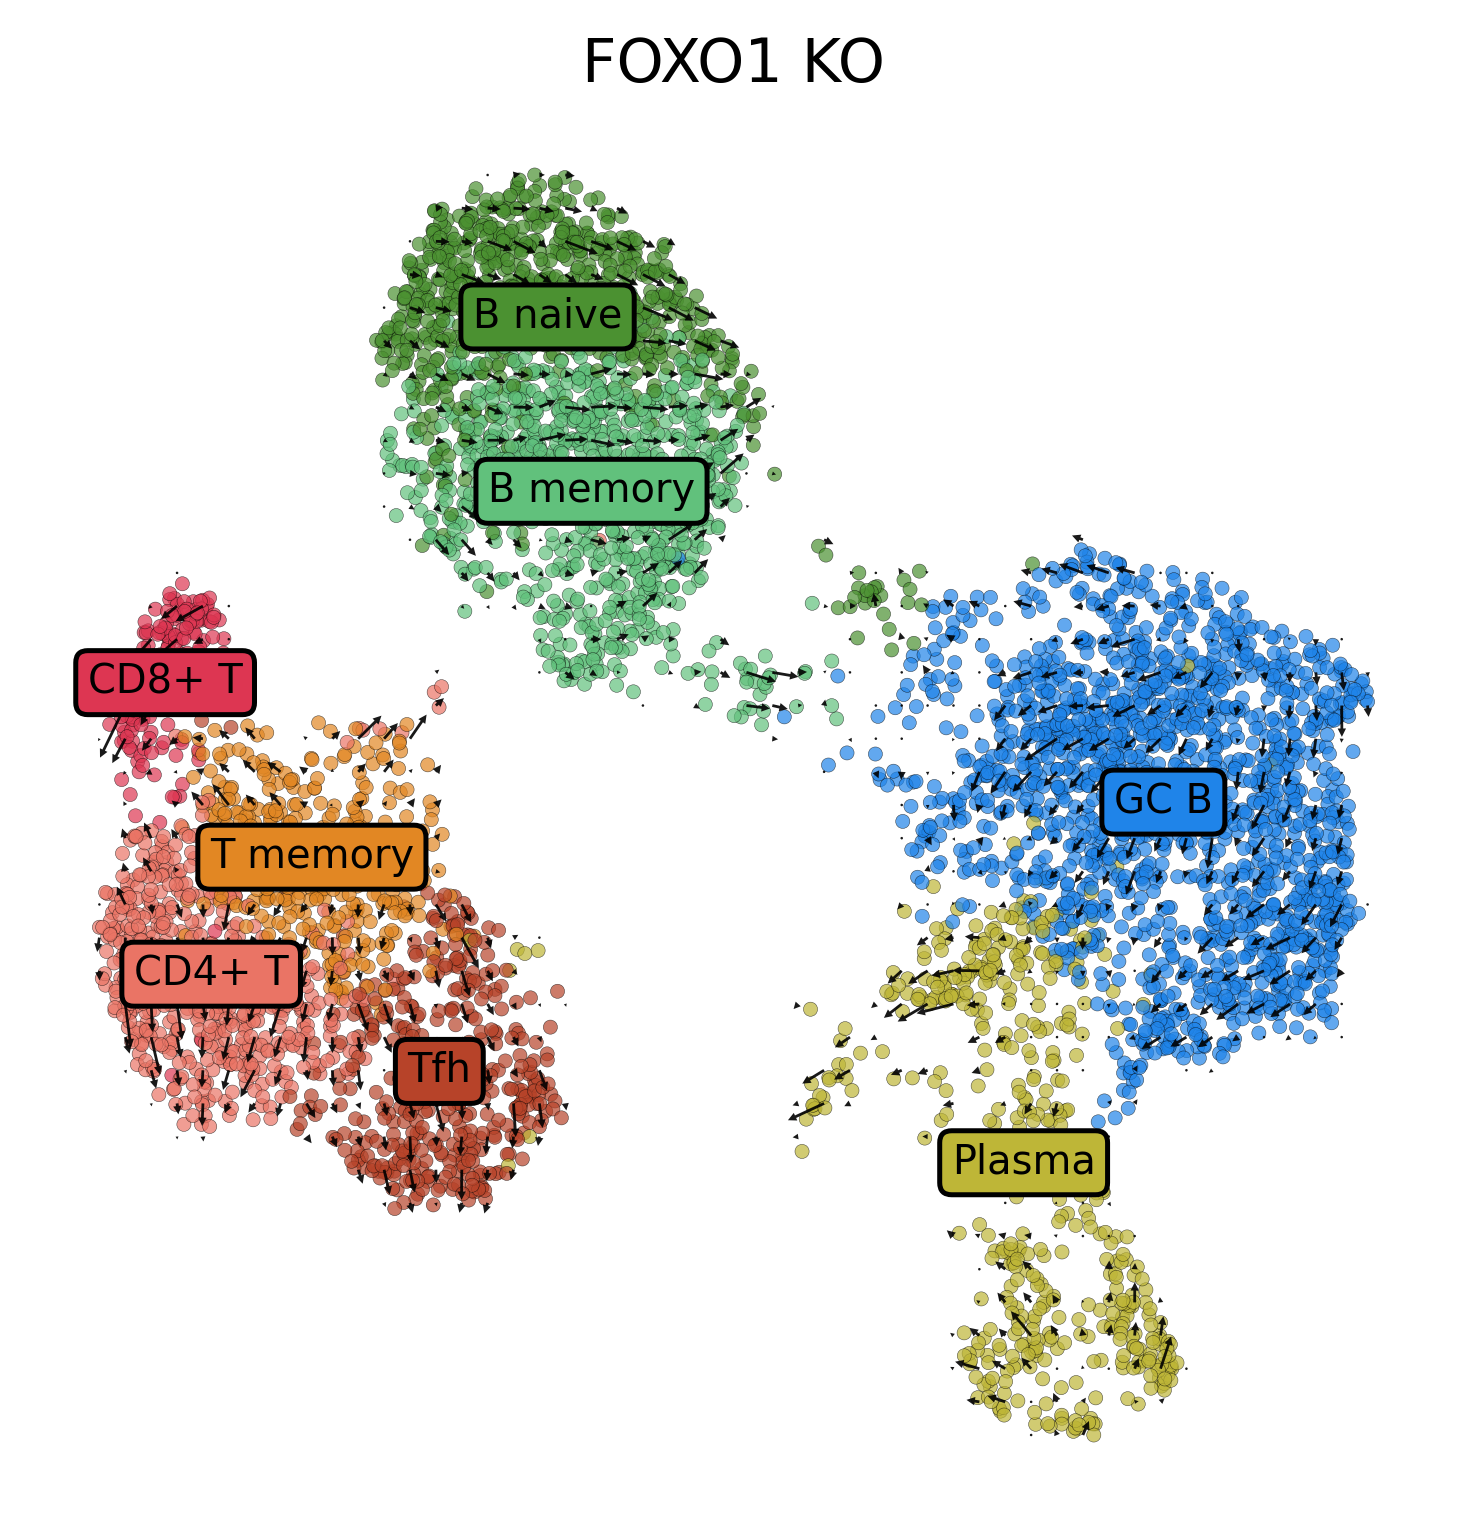

In [12]:
kotarget = 'FOXO1'
ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=2,
    vector_scale=0.5,
    figsize=(5, 5), 
    hue='cell_type_2',
    alpha=0.7,
    scatter_size=8,
    betadata_path='/Volumes/SSD/genome_screens/human_tonsil',
    legend_on_loc=True,
)
plt.title(f'{kotarget} KO')
plt.show()

In [39]:
from tqdm.notebook import tqdm

In [45]:
ko_screen = []
for kodf in tqdm(list(glob.glob('/Volumes/SSD/genome_screens/human_tonsil/*.parquet'))):
    data = (pd.read_parquet(kodf).loc[
            chart.adata.obs_names
        ]-chart.adata.to_df(layer='imputed_count')
        ).join(chart.adata.obs.cell_type_2).groupby(
            'cell_type_2'
        ).mean().abs().mean(axis=1).sort_values(
            ascending=True
        )
        
    data = data.to_frame()
    data.columns = [kodf.split('/')[-1].split('_')[0]]
    
    ko_screen.append(data)

  0%|          | 0/376 [00:00<?, ?it/s]

In [46]:
len(adata.obs.cell_type_2.unique())

8

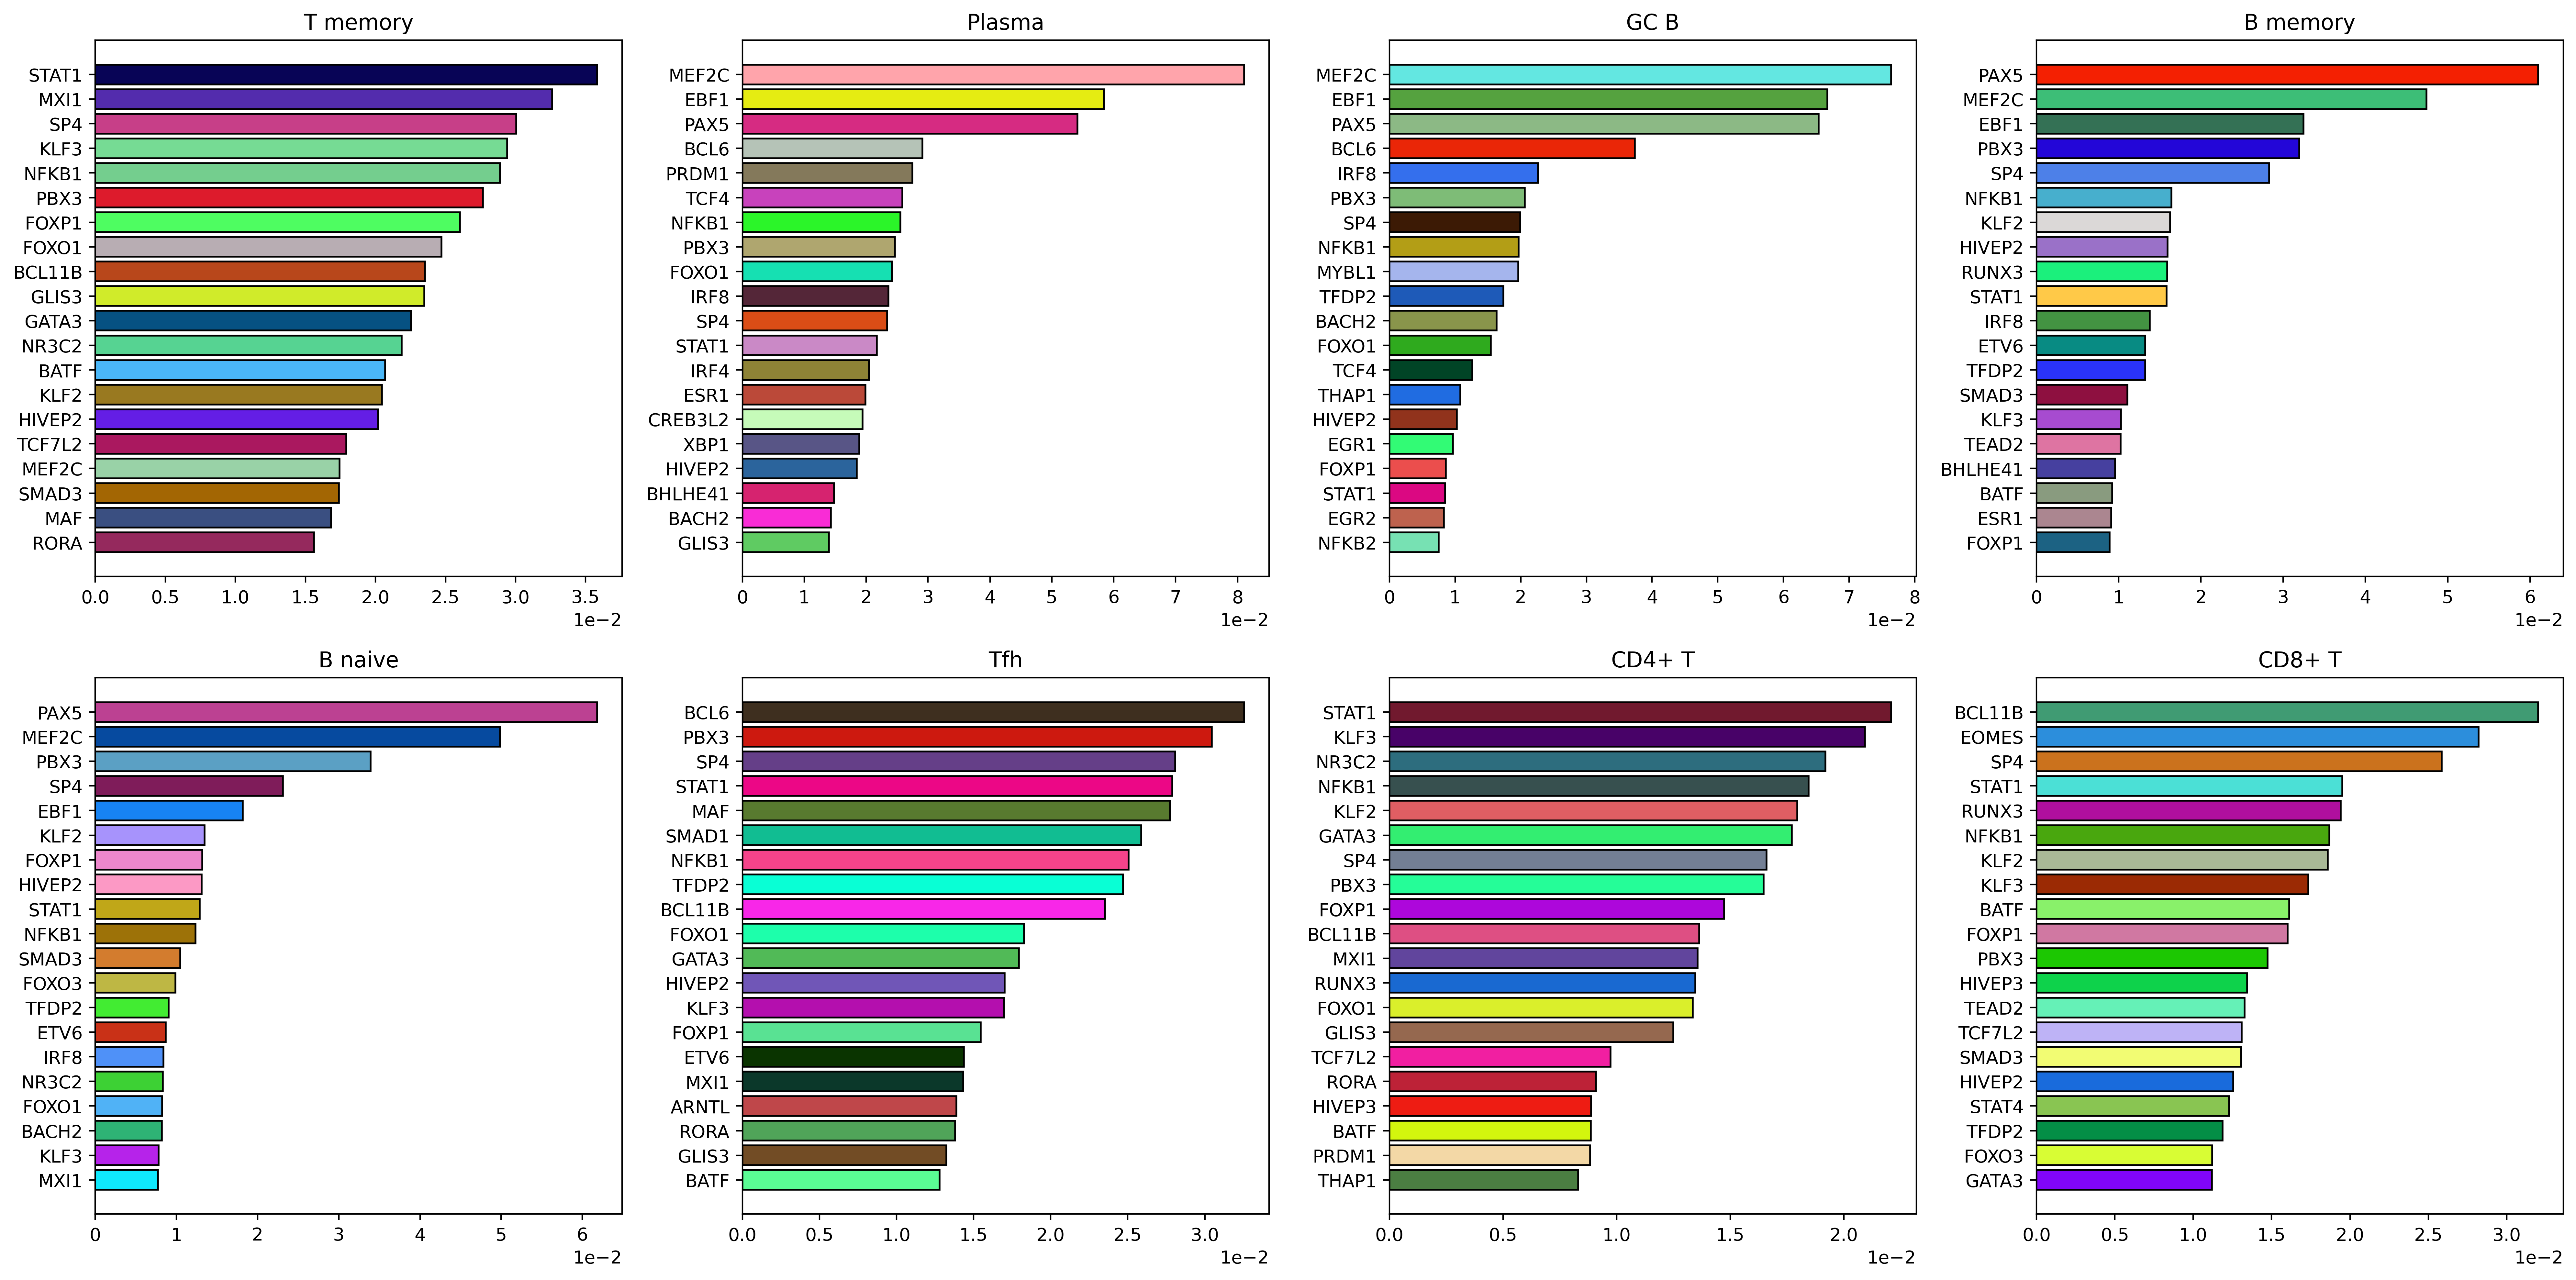

In [48]:
import matplotlib.pyplot as plt
import random

unique_cell_types = adata.obs.cell_type_2.unique()
fig, axs = plt.subplots(2, 4, figsize=(20, 10), dpi=200)
for i, cell_type in enumerate(unique_cell_types):
    row, col = divmod(i, 4)
    colors = [random.choice(['#%06X' % random.randint(0, 0xFFFFFF) for _ in range(6)]) for _ in range(20)]
    axs[row, col].barh(pd.concat(ko_screen, axis=1).loc[cell_type].sort_values(ascending=False).head(20).index, 
                       pd.concat(ko_screen, axis=1).loc[cell_type].sort_values(ascending=False).head(20).values, 
                       color=colors, linewidth=1, edgecolor='black')
    axs[row, col].set_title(cell_type)
    axs[row, col].invert_yaxis()
    axs[row, col].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()
plt.show()

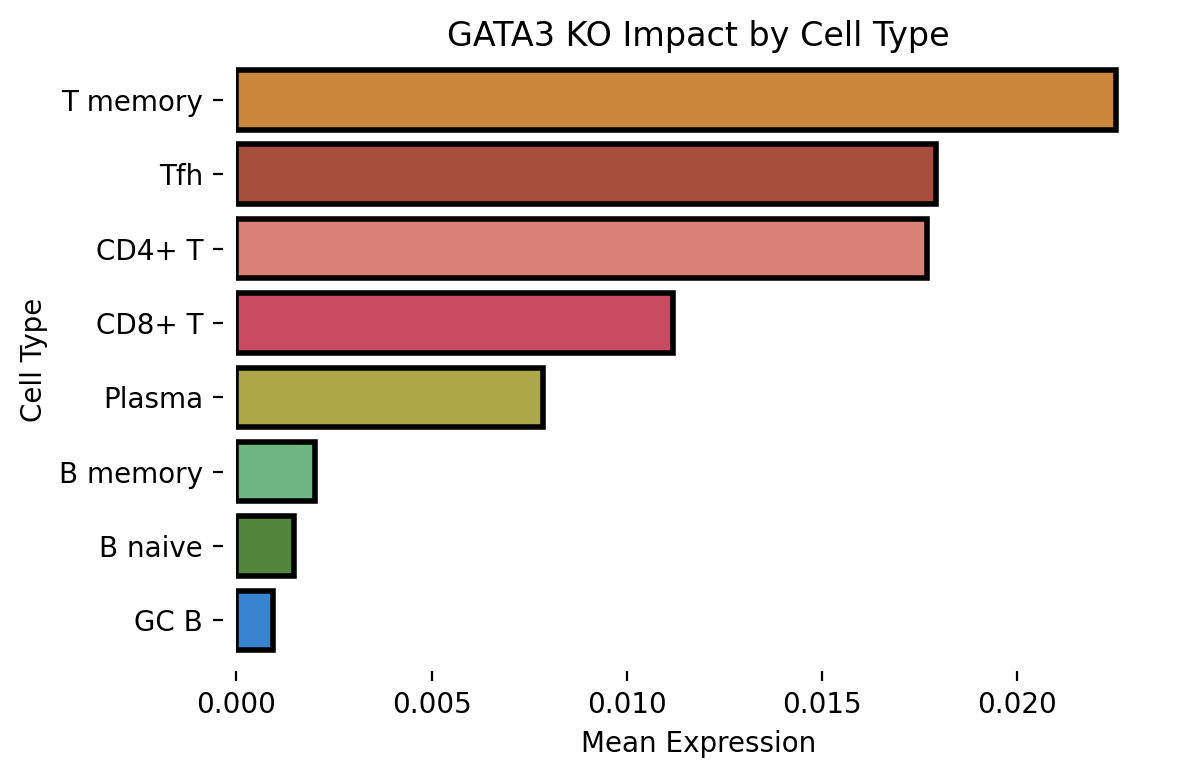

In [58]:
kotarget = 'GATA3'
data = (pd.read_parquet(
    f'/Volumes/SSD/genome_screens/human_tonsil/{kotarget}_4n_0x.parquet').loc[
        chart.adata.obs_names
    ]-chart.adata.to_df(layer='imputed_count')
    ).join(chart.adata.obs.cell_type_2).groupby(
        'cell_type_2'
    ).mean().abs().mean(axis=1).sort_values(
        ascending=True
    )

plt.figure(figsize=(6, 4), dpi=100)
sns.barplot(
    x=data.values,
    y=data.index,
    edgecolor='black',
    palette=color_dict,
    linewidth=2,
    order=data.index[::-1],
)

plt.xlabel('Mean Expression')
plt.ylabel('Cell Type')
plt.title(f'{kotarget} KO Impact by Cell Type')

sns.despine(offset=5)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [112]:
from spaceoracle.plotting.shift import estimate_transition_probabilities

embedding = adata.obsm['X_umap']
n_neighbors = 200
betadata_path = '/Volumes/SSD/genome_screens/human_tonsil'
perturbed_df = pd.read_parquet(
    f'{betadata_path}/{kotarget}_4n_0x.parquet')
delta_X = perturbed_df.loc[
    chart.adata.obs_names].values - chart.adata.layers['imputed_count']
chart.adata.layers[kotarget] = perturbed_df.loc[chart.adata.obs_names].values.copy()
corr = chart.get_corr(kotarget)
P = estimate_transition_probabilities(
    adata, delta_X, embedding, n_neighbors=n_neighbors, n_jobs=1)
del chart.adata.layers[kotarget]

In [122]:
chart.adata.obs

cell_type   author_cell_type cell_type_int leiden leiden_R  \
NAME                                                                            
AAACCCAAGCGCCTTG-1   T cells              T_CD4             7      0      0,0   
AAACCCAAGTGGACGT-1    Plasma             plasma             6      4        1   
AAACCCACAGAAGTGC-1      GC B  B_germinal_center             4      5        2   
AAACCCATCATCGCAA-1  B memory           B_memory             0      7        4   
AAACCCATCCGATCGG-1    Plasma  B_germinal_center             6      4        1   
...                      ...                ...           ...    ...      ...   
TTTGTTGCAGGGACTA-1      GC B  B_germinal_center             4      5        2   
TTTGTTGCATTGTAGC-1    Plasma             plasma             6      4        1   
TTTGTTGGTACCACGC-1      GC B  B_germinal_center             4      5        2   
TTTGTTGGTCTGTCCT-1    CD4+ T              T_CD4             2      2      0,2   
TTTGTTGTCATGCGGC-1    CD4+ T              T_CD4             2      2      0,2   

                   cell_type_2      banksy_celltypes  
NAME                                                  
AAACCCAAGCGCCTTG-1    T memory                 T_CD4  
AAACCCAAGTGGACGT-1      Plasma                plasma  
AAACCCACAGAAGTGC-1        GC B         GC Light Zone  
AAACCCATCATCGCAA-1    B memory              B_memory  
AAACCCATCCGATCGG-1      Plasma  GC Intermediate Zone  
...                        ...                   ...  
TTTGTTGCAGGGACTA-1        GC B          GC Dark Zone  
TTTGTTGCATTGTAGC-1      Plasma                plasma  
TTTGTTGGTACCACGC-1        GC B          GC Dark Zone  
TTTGTTGGTCTGTCCT-1      CD4+ T                 T_CD4  
TTTGTTGTCATGCGGC-1      CD4+ T                 T_CD4  

[5139 rows x 7 columns]

In [123]:
# chart.adata.obs = chart.adata.obs.join(pd.read_csv('banksy_celltypes.csv', index_col=0))

In [146]:
chart.adata.obs.loc[chart.adata.obs['cell_type'] == 'GC B', 'cell_type_2'] = chart.adata.obs['banksy_celltypes']

In [150]:
chart.adata.obs.cell_type_2.value_counts()

cell_type_2
GC B        1581
B memory     873
B naive      715
CD4+ T       530
Plasma       490
Tfh          404
T memory     371
CD8+ T       175
Name: count, dtype: int64

In [138]:
chart.adata.obs[chart.adata.obs.cell_type=='GC B'].cell_type_2 = None

In [140]:
chart.adata.obs[chart.adata.obs.cell_type=='GC B'].cell_type_2

NAME
AAACCCACAGAAGTGC-1    GC B
AAACGAATCCGTCCTA-1    GC B
AAACGAATCTTTGGAG-1    GC B
AAACGCTCAGCTGAAG-1    GC B
AAACGCTCAGTGTACT-1    GC B
                      ... 
TTTGGAGGTGTACGCC-1    GC B
TTTGGAGGTTAACCTG-1    GC B
TTTGGTTCATGTGACT-1    GC B
TTTGTTGCAGGGACTA-1    GC B
TTTGTTGGTACCACGC-1    GC B
Name: cell_type_2, Length: 1581, dtype: category
Categories (8, object): ['B memory', 'B naive', 'CD4+ T', 'CD8+ T', 'GC B', 'Plasma', 'T memory', 'Tfh']

In [70]:
source_ct = 'B_naive'
transition_df = chart.compute_transitions(corr, source_ct=source_ct)

In [71]:
chart.assess_transitions(
    transition_df, 
    base_celltypes=adata.obs.banksy_celltypes, 
    source_ct=source_ct
)

Source Cells: B_naive           min      mean       max
Transition Target                                      
B_naive                3.420945e-10  0.000699  0.001233
B_memory               2.023134e-10  0.000471  0.001060
pDC                    8.469155e-09  0.000053  0.010310
FDC                    4.030107e-10  0.000033  0.002592
T_CD4                  3.030271e-09  0.000030  0.000899
mDC/myeloid            1.258382e-09  0.000025  0.000575
T_CD8                  2.063119e-09  0.000024  0.003378
T_follicular_helper    2.426093e-10  0.000020  0.001501
GC Dark Zone           1.718281e-12  0.000008  0.000361
GC Light Zone          9.751556e-12  0.000007  0.000797
plasma                 8.685132e-12  0.000006  0.000128
GC Intermediate Zone   5.938835e-13  0.000006  0.000480

In [36]:
thresh = 0.00045 # need to cross this to leave base cell phenotype
allowed_fates = [
    # 'T_CD4',
    'plasma',
    'GC Light Zone',
    'B_memory',
    'GC Intermediate Zone',
    # 'T_follicular_helper',
    'GC Dark Zone',
    # 'FDC',
    'B_naive',
    # 'T_CD8',
    # 'mDC/myeloid',
    # 'pDC'
]

transitions = chart.get_cellfate(transition_df, allowed_fates, thresh)

100%|██████████| 274/274 [00:03<00:00, 84.11it/s]

Counter({'B_memory': 184, 'plasma': 70, 'GC Dark Zone': 17, 'B_naive': 2, 'GC Light Zone': 1}) 0.0004521653387598443


In [37]:
projection_params = {
    'basis': 'spatial',
    'color': 'banksy_celltypes', 
    'legend_loc': 'right',
    'recompute': True,
    'stream': False,
    'scale': 0.8,
    'alpha': 0.6,
    'size': 50,
    'show': False,
    'linewidth': 0.1,
    'palette': color_dict,
    'min_mass': 50,
    'smooth': 1.0,
    'edgecolor': 'none',
    'arrow_color':'black',
    'n_neighbors': 100,
}

In [38]:
%%capture
X_grid, V_grid = chart.get_grids(P, projection_params)
vector_field_df = chart.vector_field_df(X_grid, V_grid)


In [39]:
import alphashape

In [40]:
source_cells = adata.obs[adata.obs['banksy_celltypes'] == source_ct].index

In [41]:
adata.obs['transition'] = adata.obs['banksy_celltypes'].copy()
adata.obs.loc[source_cells, 'transition'] = np.array(transitions)
ct_points_wt, ct_points_ko = chart.make_celltype_dict()

In [42]:
delta_df = adata.to_df(layer='FOXO1') - adata.to_df(layer='imputed_count')


In [44]:
alpha_shape_1 = alphashape.alphashape(ct_points_wt['GC Light Zone'], alpha=0.04)
alpha_shape_2 = alphashape.alphashape(ct_points_wt['GC Dark Zone'], alpha=0.04)
alpha_shape_3 = alphashape.alphashape(ct_points_wt['GC Intermediate Zone'], alpha=0.04)

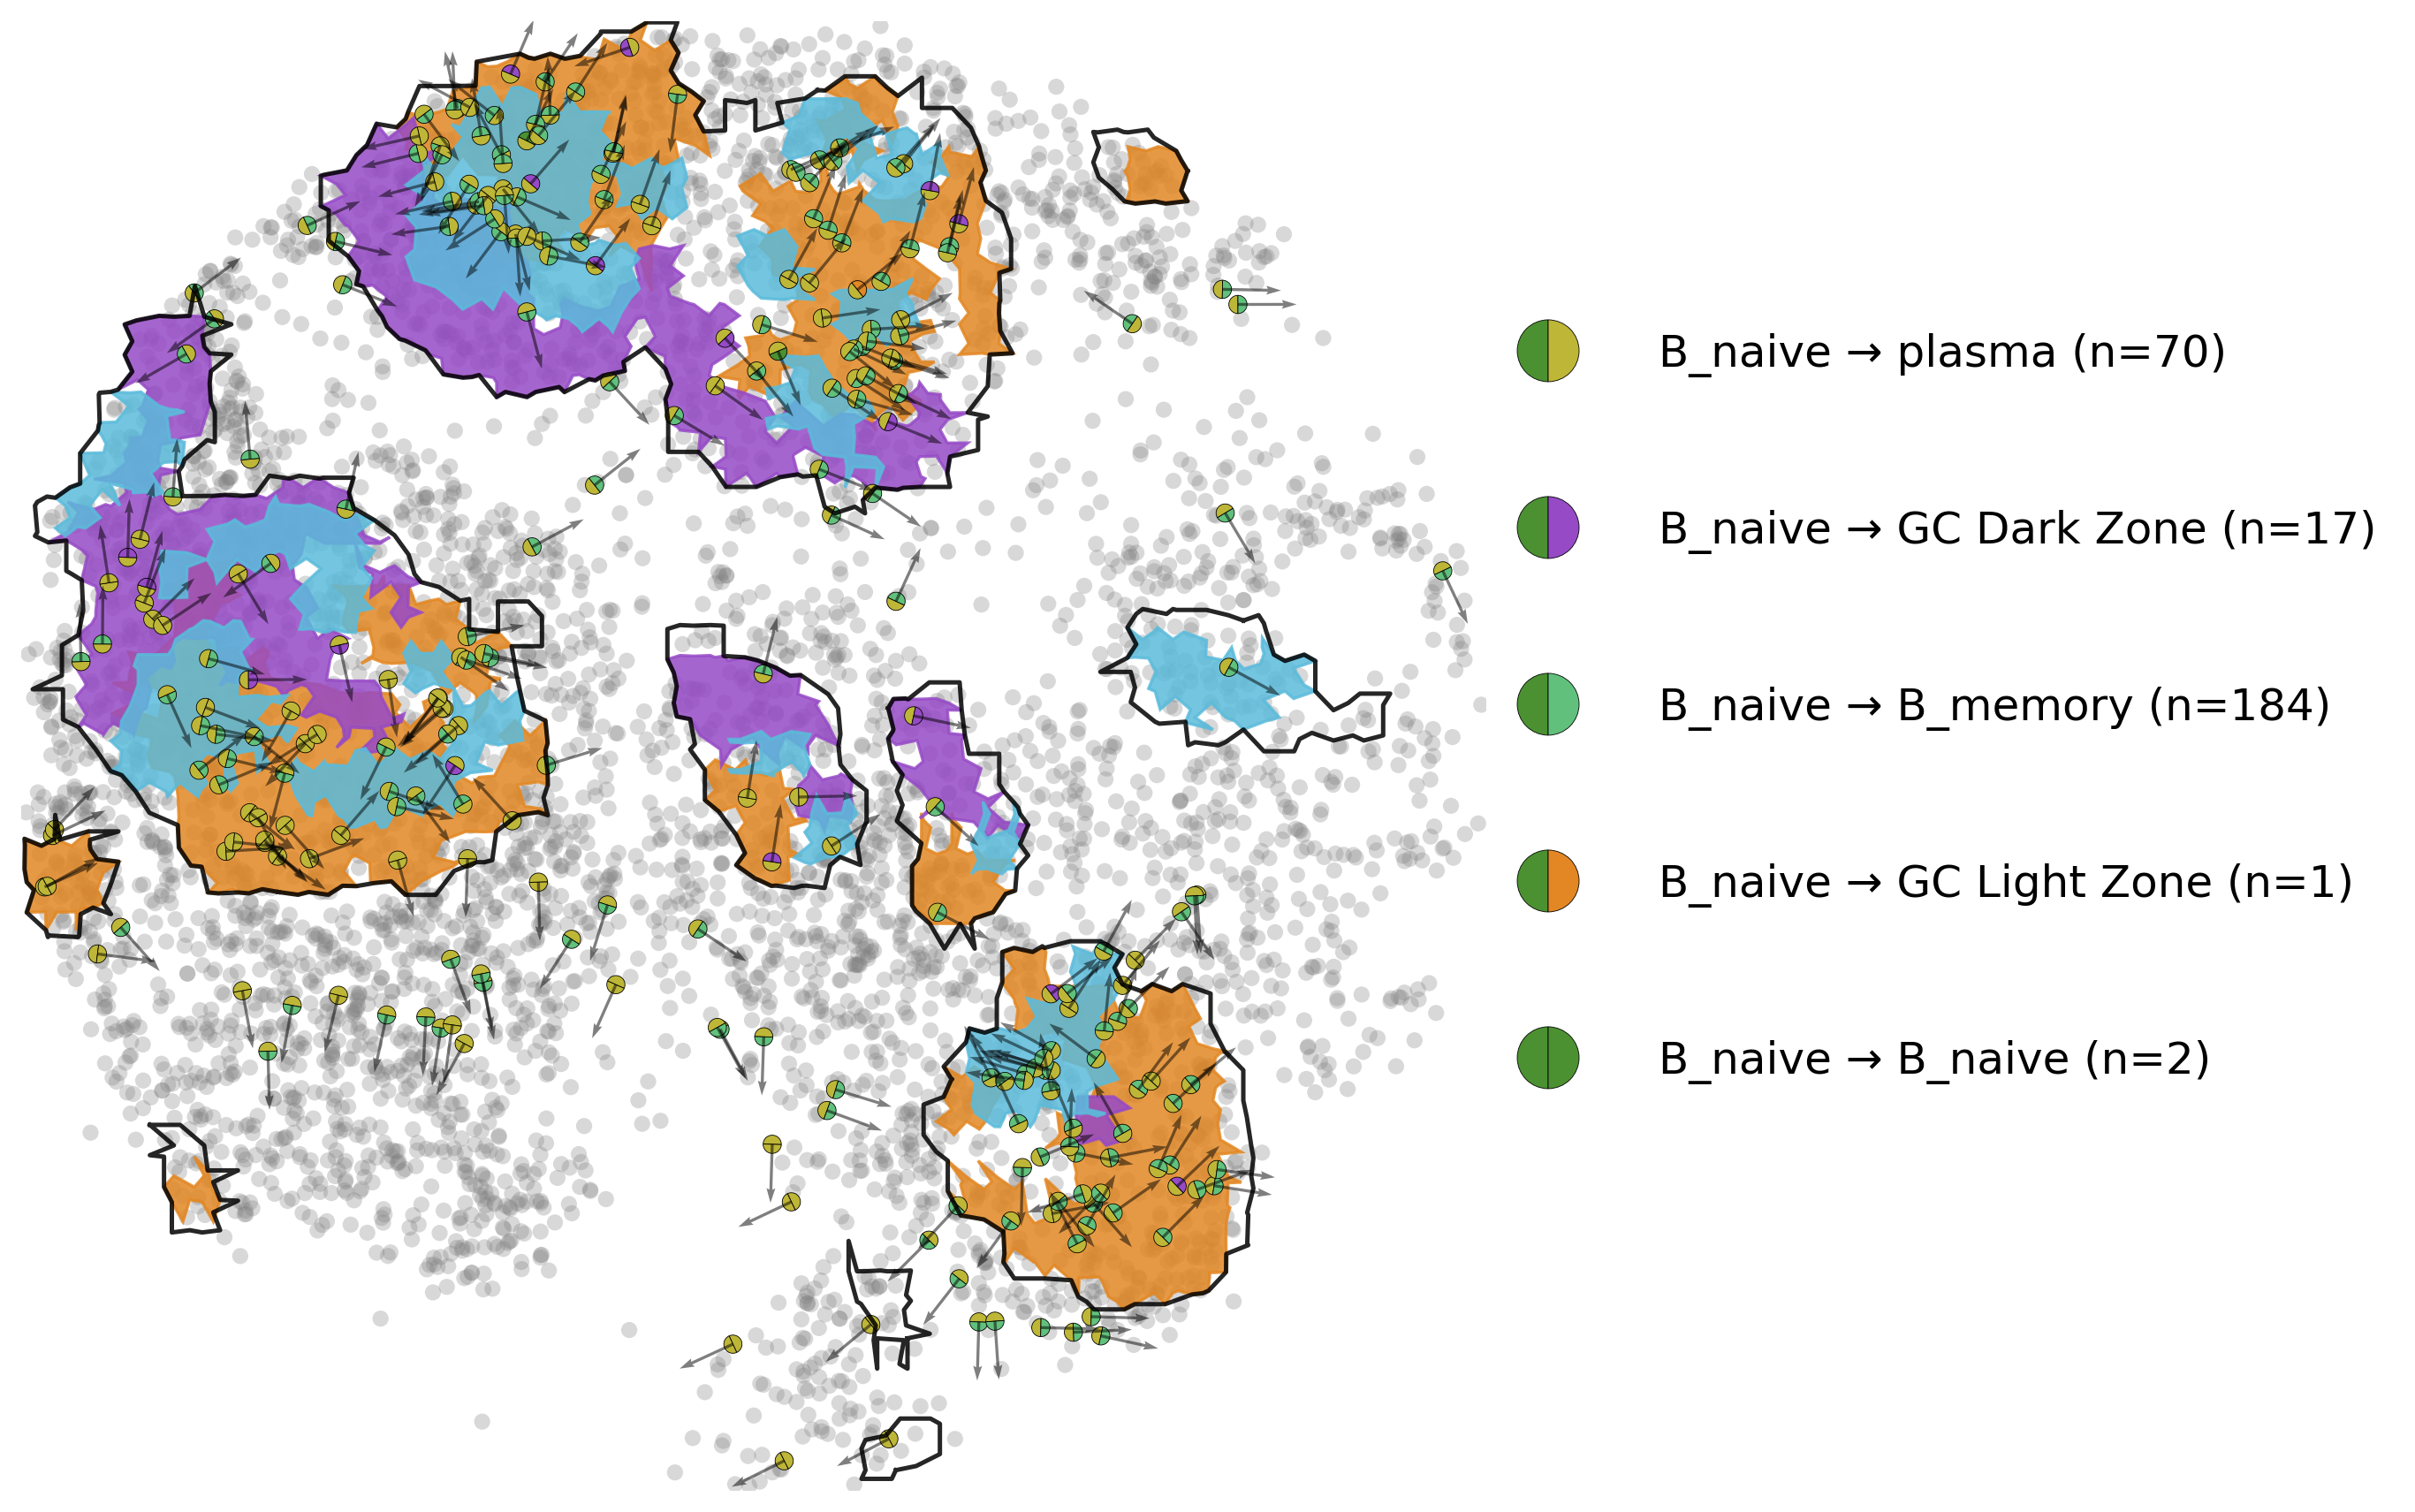

In [83]:
from matplotlib.legend_handler import HandlerTuple
import matplotlib
# Custom handler for wedge pairs in legend
class WedgePairHandler:
    def __init__(self, rotation=0):
        self.rotation = rotation
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        r = min(width, height) * 1
        center = (x0 + width/2, y0 + height/2)
        
        # Create left and right wedges with rotation
        wedge1 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=90 + self.rotation, theta2=270 + self.rotation,
            facecolor=orig_handle[0].get_facecolor(),
            edgecolor='black',
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        wedge2 = matplotlib.patches.Wedge(
            center=center,
            r=r,
            theta1=-90 + self.rotation, theta2=90 + self.rotation,
            facecolor=orig_handle[1].get_facecolor(),
            edgecolor='black', 
            linewidth=0.25,
            transform=handlebox.get_transform()
        )
        
        handlebox.add_artist(wedge1)
        handlebox.add_artist(wedge2)
        return [wedge1, wedge2]

fig, ax = plt.subplots(figsize=(20, 9), dpi=120)
data = xy.join(adata.obs)
source_data = data[data.banksy_celltypes == source_ct]
transition_data = data.loc[source_cells]

scatter = sns.scatterplot(
    data=xy.join(adata.obs),
    x='x', y='y',
    # hue='banksy_celltypes', 
    color='grey',
    s=30,
    alpha=0.3,
    edgecolor='none',
    # palette=color_dict,
    ax=ax,
)



zone_alpha = 0.85
for geom in alpha_shape_1.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

for geom in alpha_shape_2.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Dark Zone'], alpha=zone_alpha)

for geom in alpha_shape_3.geoms:
    if geom.area > 5000:
        ax.fill(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

alpha_shape_4 = alphashape.alphashape(
    np.concatenate(
        [ct_points_wt['GC Light Zone'], 
         ct_points_wt['GC Intermediate Zone'], 
         ct_points_wt['GC Dark Zone']]
        ), alpha=0.03)

for geom in alpha_shape_4.geoms:
    if geom.area > 10000:
        ax.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=zone_alpha)

# Create scatter plot with legend



    
radius = 18

angles = vector_field_df.angle

for idx, row in data.iterrows():
    if idx in source_cells:
        angle = angles[idx]
        circle1 = matplotlib.patches.Wedge((row.x, row.y), radius, 90+angle, 270+angle,
                                         facecolor=color_dict[row.banksy_celltypes],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        circle2 = matplotlib.patches.Wedge((row.x, row.y), radius, -90+angle, 90+angle,
                                         facecolor=color_dict[row.transition],
                                         alpha=1,
                                         edgecolor='black', linewidth=0.25)
        ax.add_patch(circle1)
        ax.add_patch(circle2)
    else:
        continue
        circle = plt.Circle((row.x, row.y), radius=radius//1.5,
                          facecolor='grey',
                          alpha=0.5,
                          edgecolor='none') 
        ax.add_patch(circle)
# for ii, jj in edges:
#     ax.plot(
#         points[[ii, jj], 0], 
#         points[[ii, jj], 1], 'k', 
#         linewidth=1, alpha=0.65, 
#         linestyle='--', color='red')

ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_aspect('equal')
ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
ax.set_ylim(data.y.min() - 10, data.y.max() + 10)

# Collect all unique transition types from transition_data
unique_transitions = transition_data['transition'].unique()

# Create legend elements for each transition type
legend_elements = []
labels = []

# Create legend elements with fixed angles for consistent appearance
for transition in unique_transitions:
    # Count number of transitions for this type
    n_transitions = len(transition_data[transition_data['transition'] == transition])
    
    wedge_source = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                          facecolor=color_dict[source_ct])
    wedge_transition = matplotlib.patches.Wedge((0,0), radius, 0, 0,
                                              facecolor=color_dict[transition])
    legend_elements.append((wedge_source, wedge_transition))
    labels.append(f"{source_ct} → {transition} (n={n_transitions})")

# Create the transitions legend using custom handler with 45 degree rotation
transition_legend = ax.legend(legend_elements, labels, 
                            handler_map={tuple: WedgePairHandler(rotation=0)},
                            bbox_to_anchor=(1, 0.8), 
                            # loc='center right', 
                            borderaxespad=0.,
                            fontsize=15,
                            markerscale=5,
                            labelspacing=3,
                            handletextpad=1.5, 
                            frameon=False,
                            title="")


# sns.scatterplot(
#     data=vector_field_df.join(adata.obs).query(
#         'cell_type == "B_germinal_center"'), 
#     x='x', y='y', s=50, 
#     hue='banksy_celltypes', palette=color_dict, legend=False, ax=ax)

vecdf = vector_field_df.join(adata.obs).query(
    'banksy_celltypes == "plasma"')

magn = np.sqrt(V_grid[:, 0]**2 + V_grid[:, 1]**2)

ax.quiver(vecdf['x'], vecdf['y'], 
          np.cos(np.radians(vecdf['angle'])), 
          np.sin(np.radians(vecdf['angle'])),
          scale=25, width=0.002, alpha=0.5)

# q = plt.quiver(X_grid[:, 0], X_grid[:, 1], V_grid[:, 0], V_grid[:, 1],
#             #    magnitudes, 
#                cmap='magma', 
#                linewidth=0.4,
#                scale=1000, width=0.0035, 
#                alpha=0.4, edgecolor=None)

plt.xlabel('')
plt.ylabel('')
plt.title('')

# plt.tight_layout()
# plt.savefig('/tmp/transition_figure.png', dpi=300, format='png')
plt.show()

# scatter_legend = ax.legend(
#     title="Cell Types", bbox_to_anchor=(1.5, -0.0), 
#     loc='lower right', markerscale=2)

# for lh in scatter_legend.legend_handles:
#     lh.set_alpha(1)
# ax.add_artist(scatter_legend)


In [212]:
# fig, ax = plt.subplots(figsize=(10, 10), dpi=120)
# data = xy.join(adata.obs)
# source_data = data[data.banksy_celltypes == source_ct]
# transition_data = data.loc[source_cells]

# scatter = sns.scatterplot(
#     data=xy.join(adata.obs),
#     x='x', y='y',
#     # hue='banksy_celltypes', 
#     color='grey',
#     s=30,
#     alpha=0.3,
#     edgecolor='none',
#     # palette=color_dict,
#     ax=ax,
# )

# alpha_shape_1 = alphashape.alphashape(ct_points_ko['GC Light Zone'], alpha=0.04)
# alpha_shape_2 = alphashape.alphashape(ct_points_ko['GC Dark Zone'], alpha=0.04)
# alpha_shape_3 = alphashape.alphashape(ct_points_ko['GC Intermediate Zone'], alpha=0.04)

# zone_alpha = 0.85
# for geom in alpha_shape_1.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Light Zone'], alpha=zone_alpha)
        

# for geom in alpha_shape_2.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Dark Zone'], alpha=zone_alpha)

# for geom in alpha_shape_3.geoms:
#     if geom.area > 5000:
#         ax.fill(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color=color_dict['GC Intermediate Zone'], alpha=zone_alpha)

# alpha_shape_4 = alphashape.alphashape(
#     np.concatenate(
#         [ct_points_wt['GC Light Zone'], 
#          ct_points_wt['GC Intermediate Zone'], 
#          ct_points_wt['GC Dark Zone']]
#         ), alpha=0.03)

# for geom in alpha_shape_4.geoms:
#     if geom.area > 10000:
#         ax.plot(
#             geom.exterior.xy[0], 
#             geom.exterior.xy[1], 
#             color='black', alpha=zone_alpha)

# ax.set_frame_on(False)
# ax.set_xticks([])
# ax.set_yticks([])
# ax.set_xlabel('')
# ax.set_ylabel('')
# ax.set_aspect('equal')
# ax.set_xlim(data.x.min() - 10, data.x.max() + 10)
# ax.set_ylim(data.y.min() - 10, data.y.max() + 10)
# plt.show()